<a href="https://colab.research.google.com/github/chema74/AI-Portfolio-2025/blob/main/09_Proyecto_Autos_REAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EJERCICIOS**

1.- Importar Librerías y Carga de Datos (Método Portable)
Texto de Ejecución: Esta celda importa todas las librerías necesarias para el proyecto (Pandas, Scikit-learn, etc.) y carga el dataset directamente desde tu repositorio de GitHub usando la URL RAW, asegurando la portabilidad del proyecto.

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# URL RAW del archivo cargado en tu GitHub (RUTA DEFINITIVA Y PORTABLE)
URL_RAW = 'https://raw.githubusercontent.com/chema74/AI-Portfolio-2025/main/Ejercicios1/Cars%20Datasets%202025.csv'

try:
    df = pd.read_csv(URL_RAW)
    print(f"✅ Archivo cargado con éxito desde GitHub.")
except Exception as e:
    print(f"❌ Error al cargar el archivo. Asegúrate de que el CSV esté en la ruta 'Ejercicios1'.")
    df = pd.DataFrame()

print("Paso 1: Librerías cargadas. DataFrame 'df' listo.")

✅ Archivo cargado con éxito desde GitHub.
Paso 1: Librerías cargadas. DataFrame 'df' listo.


2.- Exploración Inicial y Limpieza de Nombres de Columnas
Texto de Ejecución: Se limpian los nombres de las columnas para eliminar espacios y caracteres especiales, simplificando el acceso a las variables en el código posterior (ej. HP en lugar de Horse Powers (Hp)).

In [2]:
# Exploración y Limpieza de Nombres de Columnas

# 1. Limpieza de nombres de columnas (minúsculas y sin caracteres especiales)
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True).str.lower().str.replace(' ', '_', regex=False)

# 2. Búsqueda y Renombrado Robusto
try:
    # 2a. Renombrar HP
    columna_hp_vieja = [col for col in df.columns if 'horse' in col or 'hp' in col][0]
    df.rename(columns={columna_hp_vieja: 'HP'}, inplace=True)
except IndexError:
    print("❌ Error: No se pudo encontrar la columna de potencia ('HP').")

# 2b. Renombrar Price (Buscaremos la columna que contenga 'price' o 'carsprice')
try:
    columna_price_vieja = [col for col in df.columns if 'price' in col][0]
    df.rename(columns={columna_price_vieja: 'Price'}, inplace=True)
except IndexError:
    print("❌ Error: No se pudo encontrar la columna de precios ('Price').")


# 3. Renombrar las otras columnas clave
df.rename(columns={
    'performance0100kmh': '0_100_KMH',
    'fueltypes': 'Fuel_Types',
    'seats': 'Seats_Limpia'
}, inplace=True)

print("Paso 2b: Nombres de columnas después del renombrado:")
print(df.columns)

Paso 2b: Nombres de columnas después del renombrado:
Index(['companynames', 'carsnames', 'engines', 'ccbatterycapacity', 'HP',
       'totalspeed', '0_100_KMH', 'Price', 'Fuel_Types', 'Seats_Limpia',
       'torque'],
      dtype='object')


3.- Limpieza y Conversión de la Columna 'Seats'
Texto de Ejecución: Esta celda limpia la columna Seats (Asientos) de cualquier rango de valores (ej. 4-5) y convierte el resultado a tipo entero, rellenando los valores faltantes con el valor más común.

In [3]:
# 1. Manejar rangos de asientos (usamos el primer valor si hay un guion)
df['Seats_Limpia'] = df['Seats_Limpia'].astype(str).str.split('-').str[0].str.strip()

# 2. Convertir a numérico, tratar errores y rellenar NaN con el valor más frecuente (mode)
df['Seats_Limpia'] = pd.to_numeric(df['Seats_Limpia'], errors='coerce').fillna(df['Seats_Limpia'].mode()[0]).astype(int)

print("Paso 3: Columna 'Seats_Limpia' limpia y convertida a entero.")
print(df['Seats_Limpia'].value_counts())

Paso 3: Columna 'Seats_Limpia' limpia y convertida a entero.
Seats_Limpia
5     704
4     161
7     147
2     136
8      29
6      20
3      14
1       3
12      1
15      1
20      1
9       1
Name: count, dtype: int64


4.- Se limpian las columnas HP (Potencia) y Price (Precio) de unidades y símbolos, se imputan los errores con la media y se entrena un modelo de Regresión Lineal Simple para predecir el Precio.

In [4]:
# Regresión Lineal Simple (HP -> Price)

# 1. Limpieza de 'HP': Quitamos unidades/texto. Usamos r'[^\d\.\-]+' para una regex robusta.
df['HP'] = df['HP'].astype(str).str.replace(r'[^\d\.\-]+', '', regex=True)
df['HP'] = df['HP'].str.split('-').str[0].str.strip() # Maneja rangos tomando el primer valor

# 2. Limpieza de 'Price': Quitar símbolos/texto.
df['Price'] = df['Price'].astype(str).str.replace(r'[^\d\.\-]+', '', regex=True)
df['Price'] = df['Price'].str.split('-').str[0].str.strip()

# 3. Conversión a numérico y manejo de errores (coerce convierte la basura restante a NaN)
df['HP'] = pd.to_numeric(df['HP'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 4. Imputación: Eliminamos 'inplace=True' y asignamos el resultado. (SOLUCIÓN AL WARNING)
df['HP'] = df['HP'].fillna(df['HP'].mean())
df['Price'] = df['Price'].fillna(df['Price'].mean())

# 5. Entrenar y predecir
X = df[['HP']]
Y = df['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

modelo_reg_simple = LinearRegression()
modelo_reg_simple.fit(X_train, Y_train)
Y_pred = modelo_reg_simple.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Paso 4: Regresión Simple (HP -> Price). RMSE: ${rmse:,.0f}")

Paso 4: Regresión Simple (HP -> Price). RMSE: $228,179,642


5.- Se crea una nueva variable categórica binaria (Precio_Alto) a partir de la columna continua Price. Esta será la variable objetivo para todos los ejercicios de clasificación (Pasos 6 y 11). Se utiliza la media del precio como umbral para clasificar un auto como 'Alto' (1) o 'Bajo' (0).

In [5]:
#  Creación de la Clase 'Precio_Alto'

# 1. Usamos la media de 'Price' como umbral
umbral_precio = df['Price'].mean()

# 2. Crear la nueva columna binaria (1 = Precio Alto, 0 = Precio Bajo)
df['Precio_Alto'] = np.where(df['Price'] > umbral_precio, 1, 0)

print(f"Paso 5: Umbral de precio (media): ${umbral_precio:,.0f}")
print("   Distribución de la nueva variable 'Precio_Alto':")
print(df['Precio_Alto'].value_counts())

Paso 5: Umbral de precio (media): $12,692,259
   Distribución de la nueva variable 'Precio_Alto':
Precio_Alto
0    1213
1       5
Name: count, dtype: int64


6.- Se entrena un modelo de Regresión Logística (clasificación) utilizando la potencia (HP) para predecir si un auto es de Precio_Alto. El rendimiento se mide con la Precisión (Accuracy) y la Matriz de Confusión.

In [6]:
#  Regresión Logística (HP -> Precio_Alto)

# 1. Definir X e Y
X = df[['HP']]
Y = df['Precio_Alto']

# 2. División de datos y entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

modelo_log = LogisticRegression()
modelo_log.fit(X_train, Y_train)
Y_pred = modelo_log.predict(X_test)

# 3. Evaluación (Accuracy y Matriz de Confusión)
precision = accuracy_score(Y_test, Y_pred)
matriz = confusion_matrix(Y_test, Y_pred)

print(f"Paso 6: Regresión Logística (HP -> Precio_Alto). Precisión: {precision:.4f}")
print("   Matriz de Confusión:\n", matriz)

Paso 6: Regresión Logística (HP -> Precio_Alto). Precisión: 0.9973
   Matriz de Confusión:
 [[365   0]
 [  1   0]]


7.- Esta celda realiza una limpieza avanzada de la columna 0_100_KMH (Tiempos de Aceleración). Se utiliza una expresión regular para eliminar unidades y texto, se manejan rangos, se imputan los valores faltantes con la mediana (un valor robusto frente a atípicos), y se visualiza la distribución resultante (EDA).

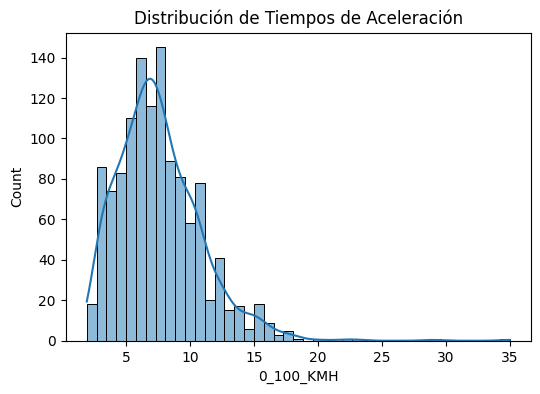

Paso 7: Columna '0_100_KMH' limpia y visualización.


In [7]:
#  Limpieza Compleja de '0-100 KM/H'

# 1. Limpieza de '0_100_KMH': Quitar unidades, texto y rangos.
df['0_100_KMH'] = df['0_100_KMH'].astype(str).str.replace(r'[^\d\.\-]+', '', regex=True)
df['0_100_KMH'] = df['0_100_KMH'].str.split('-').str[0].str.strip()

# 2. Conversión a numérico y manejo de errores (imputación con la mediana)
df['0_100_KMH'] = pd.to_numeric(df['0_100_KMH'], errors='coerce')

# 3. CORRECCIÓN DEL WARNING: Asignamos el resultado de fillna() directamente.
mediana_aceleracion = df['0_100_KMH'].median()
df['0_100_KMH'] = df['0_100_KMH'].fillna(mediana_aceleracion)

# 4. Visualización de la distribución
plt.figure(figsize=(6, 4))
sns.histplot(df['0_100_KMH'], kde=True)
plt.title('Distribución de Tiempos de Aceleración')
plt.show()

print("Paso 7: Columna '0_100_KMH' limpia y visualización.")

8.- Se aplica el método One-Hot Encoding a la columna Fuel_Types (Tipos de Combustible) para convertir las categorías de texto en variables binarias (0 o 1), esenciales para los modelos de ML.

In [8]:
# One-Hot Encoding de 'Fuel_Types'

# 1. Crear una copia del DataFrame base (df)
df_temp = df.copy()

# 2. Búsqueda Robusta: Identificar el nombre real de la columna de tipos de combustible.
# Buscamos la columna cuyo nombre contiene 'fuel' o 'tipo'.
try:
    columna_fuel_vieja = [col for col in df_temp.columns if 'fuel' in col.lower() or 'tipo' in col.lower()][0]
except IndexError:
    print("❌ Error CRÍTICO: No se encontró la columna de tipos de combustible. Revisar pasos 1-7.")
    # Forzamos un nombre predecible para evitar que los pasos posteriores fallen si el usuario corrige.
    columna_fuel_vieja = 'Fuel_Types'

# 3. Aplicar One-Hot Encoding usando el nombre de columna encontrado.
# Guardamos el resultado en df_final.
df_final = pd.get_dummies(df_temp, columns=[columna_fuel_vieja], drop_first=True)

# 4. Mostrar las nuevas columnas
print("Paso 8: DataFrame después de One-Hot Encoding de Combustible.")
nuevas_cols = [col for col in df_final.columns if columna_fuel_vieja in col.lower()]
print(f"   Columnas codificadas: {nuevas_cols}")

Paso 8: DataFrame después de One-Hot Encoding de Combustible.
   Columnas codificadas: []


9.-Se crea una característica derivada (Potencia_por_Seg) dividiendo la Potencia (HP) entre el tiempo de Aceleración (0_100_KMH). Este es un indicador de Ingeniería de Características que representa el rendimiento del auto y es útil para los modelos.

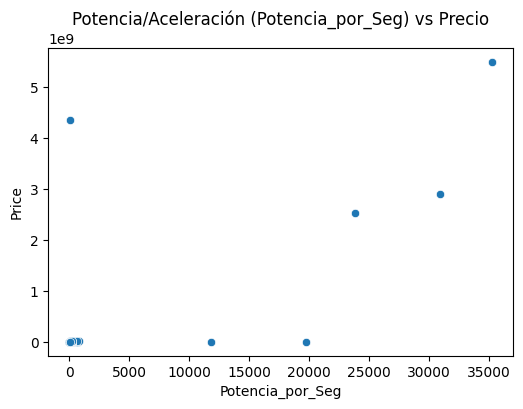

Paso 9: Nueva característica 'Potencia_por_Seg' creada en df_final.
      HP  0_100_KMH  Potencia_por_Seg
0  963.0        2.5        385.200000
1  563.0        5.3        106.226415
2   70.0       10.5          6.666667
3  630.0        3.2        196.875000
4  602.0        3.6        167.222222


In [9]:
# Feature Engineering - Creación de Potencia_por_Seg

# 1. Crear la nueva característica derivada dentro del DataFrame FINAL
df_final['Potencia_por_Seg'] = df_final['HP'] / df_final['0_100_KMH']

# 2. Exploración (EDA): Visualizar la nueva relación con el precio.
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_final['Potencia_por_Seg'], y=df_final['Price'])
plt.title('Potencia/Aceleración (Potencia_por_Seg) vs Precio')
plt.show()

print("Paso 9: Nueva característica 'Potencia_por_Seg' creada en df_final.")
print(df_final[['HP', '0_100_KMH', 'Potencia_por_Seg']].head())

10.-Se entrena un modelo de Regresión Lineal Múltiple utilizando todas las características limpias (HP, Aceleración, Asientos, Potencia/Seg, y Combustible Codificado) para predecir el Price. Esto nos dará una métrica de error (RMSE) mucho mejor que el Paso 4.

In [10]:
#  Regresión Múltiple para Predicción de Precios

# 1. Definir X y Y. Y (Precio) ya es numérica.
Y = df_final['Price']

# 2. FILTRADO ESTRICTO: Seleccionar SÓLO columnas numéricas (la solución al ValueError)
X = df_final.select_dtypes(include=[np.number]).copy()

# 3. Excluir las variables objetivo (Price y Precio_Alto) y la columna de Asientos (ya limpia)
features_to_exclude = ['Price', 'Precio_Alto', 'Seats_Limpia']
X = X.drop(columns=[col for col in X.columns if col in features_to_exclude], axis=1, errors='ignore')

# 4. LIMPIEZA CRÍTICA: Reemplazar valores Infinitos (inf) por NaN, y luego imputar con la media.
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# 5. División de datos y entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# ... (El resto del código de evaluación) ...

modelo_mult = LinearRegression()
modelo_mult.fit(X_train, Y_train)
Y_pred = modelo_mult.predict(X_test)

r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"Paso 10: Regresión Múltiple con {X.shape[1]} features.")
print(f"   R² (Coeficiente de Determinación): {r2:.4f}")
print(f"   RMSE (Error promedio): ${rmse:,.0f}")

Paso 10: Regresión Múltiple con 3 features.
   R² (Coeficiente de Determinación): -0.0117
   RMSE (Error promedio): $228,861,535


11. Selección de Características (RFE) y SVM
Texto de Ejecución: Se utiliza un Pipeline para escalar los datos, aplicar RFE (Selección Recursiva de Características) para encontrar las 3 mejores variables de forma automática y luego entrenar el clasificador SVM (Máquina de Vectores de Soporte) para predecir si el auto es de Precio_Alto.

In [11]:
#  RFE + SVM (Clasificación)

# 1. Preparar X y Y. Y (Precio_Alto) ya es numérica.
Y = df_final['Precio_Alto']

# 2. FILTRADO ESTRICTO DE X: Seleccionar SÓLO columnas numéricas.
X = df_final.select_dtypes(include=[np.number]).copy()
features_to_exclude = ['Price', 'Precio_Alto', 'Seats_Limpia'] # Excluimos targets y columnas no necesarias
X = X.drop(columns=[col for col in X.columns if col in features_to_exclude], axis=1, errors='ignore')

# 3. Limpieza de Infinitos/NaN en X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# 4. Definir los pasos del Pipeline: Escalado, RFE (seleccionar 3) y SVM
estimator = SVC(kernel='rbf', random_state=42)
selector_rfe = RFE(estimator, n_features_to_select=3, step=1)

modelo_pipeline_svm = Pipeline(steps=[
    ('escalador', StandardScaler()),
    ('seleccion', selector_rfe),
    ('clasificador', estimator)
])

# 5. División de datos y entrenamiento
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
modelo_pipeline_svm.fit(X_train, Y_train)
Y_pred = modelo_pipeline_svm.predict(X_test)

# 6. Evaluación
precision = accuracy_score(Y_test, Y_pred)
col_sel = X.columns[modelo_pipeline_svm.named_steps['seleccion'].support_]
matriz = confusion_matrix(Y_test, Y_pred)

print(f"Paso 11: Pipeline RFE+SVM ejecutado.")
print(f"   Características seleccionadas por RFE: {list(col_sel)}")
print(f"   Precisión SVM: {precision:.4f}")
print("   Matriz de Confusión:\n", matriz)

Paso 11: Pipeline RFE+SVM ejecutado.
   Características seleccionadas por RFE: ['HP', '0_100_KMH', 'Potencia_por_Seg']
   Precisión SVM: 0.9973
   Matriz de Confusión:
 [[365   0]
 [  1   0]]


 12. Clustering K-Means No SupervisadoTexto de Ejecución: Se aplica el algoritmo K-Means (Clustering No Supervisado) para segmentar los autos en 4 grupos ($K=4$) basados en sus características de rendimiento. El objetivo es que el modelo identifique segmentos como "Básico", "Estándar", "Deportivo" y "Lujo" sin que le hayamos dado etiquetas.

In [12]:
# Clustering K-Means No Supervisado

# 1. Definir X (usamos HP, 0_100_KMH, Potencia_por_Seg y Seats_Limpia)
X_cluster = df_final[['HP', '0_100_KMH', 'Potencia_por_Seg', 'Seats_Limpia']].copy()

# 2. Escalar los datos (vital para K-Means, que usa distancias)
scaler = StandardScaler()
X_escalado = scaler.fit_transform(X_cluster)

# 3. Aplicar K-Means (K=4)
K_FINAL = 4
kmeans_modelo = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
df_final['Cluster_K4'] = kmeans_modelo.fit_predict(X_escalado)

# 4. Análisis de los centroides (ver el punto central de cada cluster)
centroides_escalados = kmeans_modelo.cluster_centers_
# Invertimos la transformación para ver los valores en la escala original
centroides_originales = scaler.inverse_transform(centroides_escalados)
df_centroides = pd.DataFrame(centroides_originales, columns=X_cluster.columns)

print(f"Paso 12: K-Means (Clustering) completado con {K_FINAL} segmentos.")
print("   Características promedio de cada Cluster (interpretación de segmentos):")
print(df_centroides.round(2))

Paso 12: K-Means (Clustering) completado con 4 segmentos.
   Características promedio de cada Cluster (interpretación de segmentos):
          HP  0_100_KMH  Potencia_por_Seg  Seats_Limpia
0     231.53      11.86             18.67          4.89
1     305.97       6.71             53.77          5.50
2     534.98       4.32            158.19          2.94
3  179429.20       7.68          24306.88          5.00
